# Pace of Play analysis

This notebook is dedicated to pace of play analysis and visualizations

Import necessary libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

Import combined data from previously generated csv

In [2]:
combined_data = pd.read_csv("combined_stats.csv")
combined_data.head()

,game_id,season,week,temp,wind,calendar_week,focus_team,focus_score,focus_temp_delta,did_win,avg_temp,attempts,carries,passing_epa,rushing_epa,conventional_plays_ran,pass_to_run_ratio
0,2015_01_PIT_NE,2015,1,65.0,7.0,37,NE,28,-1.093469,True,66.093469,32,24,15.961351,-0.252627,56,1.333333
1,2015_01_IND_BUF,2015,1,56.0,15.0,37,BUF,27,-9.687551,True,65.687551,19,36,9.972638,-2.539012,55,0.527778
2,2015_01_GB_CHI,2015,1,72.0,11.0,37,CHI,23,2.529143,False,69.470857,36,33,0.229273,7.547915,69,1.090909
3,2015_01_KC_HOU,2015,1,70.0,0.0,37,HOU,20,0.000000,False,70.000000,47,21,-6.469611,-4.144401,68,2.238095
4,2015_01_CAR_JAX,2015,1,77.0,7.0,37,JAX,9,-2.510000,False,79.510000,40,21,-15.522407,-0.896787,61,1.904762


Filter for the columns that matter to us for this analysis

In [3]:
pace_of_play_data = combined_data[["game_id", "temp", "wind", "focus_temp_delta", "attempts", "carries", "conventional_plays_ran"]]
pace_of_play_data

,game_id,temp,wind,focus_temp_delta,attempts,carries,conventional_plays_ran
0,2015_01_PIT_NE,65.0,7.0,-1.093469,32,24,56
1,2015_01_IND_BUF,56.0,15.0,-9.687551,19,36,55
2,2015_01_GB_CHI,72.0,11.0,2.529143,36,33,69
3,2015_01_KC_HOU,70.0,0.0,0.000000,47,21,68
4,2015_01_CAR_JAX,77.0,7.0,-2.510000,40,21,61
...,...,...,...,...,...,...,...
4899,2024_18_KC_DEN,28.0,5.0,-1.048000,17,11,28
4900,2024_18_SEA_LA,70.0,0.0,27.069714,27,24,51
4901,2024_18_LAC_LV,70.0,0.0,0.000000,36,35,71
4902,2024_18_MIA_NYJ,34.0,10.0,-35.752527,41,23,64


Fisrt, let's just take a look at the distribution of our temp deltas

Text(0.5, 0.98, 'Histogram of focus_temp_delta')

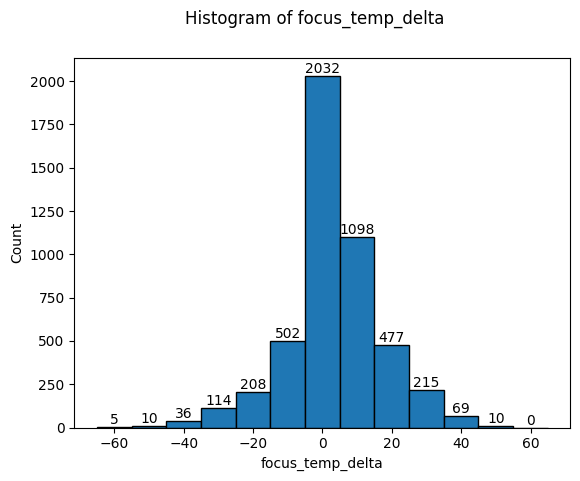

In [4]:
import numpy as np

# Calculate bin edges so that the middle bin is centered on zero
counts, bins, patches = plt.hist(combined_data["focus_temp_delta"], bins=[-65, -55, -45, -35, -25, -15, -5, 5, 15, 25, 35, 45, 55, 65], edgecolor='black')
for i in range(len(patches)):
    plt.text(
        (bins[i] + bins[i+1]) / 2,
        counts[i],
        str(int(counts[i])),
        ha='center',
        va='bottom'
    )
plt.xlabel("focus_temp_delta")
plt.ylabel("Count")
plt.suptitle("Histogram of focus_temp_delta")

Next, let's label our deltas into 3 categories. Cold (delta is <-35), hot (delta >35), and mild.

As seen in the counts below, our sample size is much smaller for cold and hot labels than for mild.

In [5]:
pace_of_play_data["category"] = pace_of_play_data["focus_temp_delta"].apply(lambda x: "Cold" if x < -35 else ("Hot" if x > 35 else "Mild"))
pace_of_play_data["category"].value_counts()

category
Mild    4774
Hot       79
Cold      51
Name: count, dtype: int64

Next, let's generate a stacked bar chart showing the carries, attempts, and total conventional plays for each label.

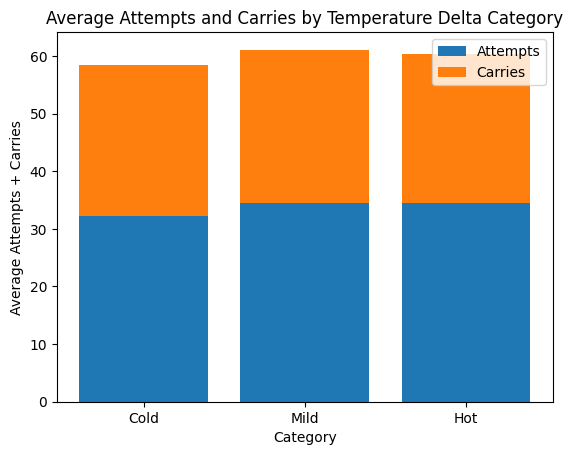

In [6]:
category_order = ["Cold", "Mild", "Hot"]
category_counts = pace_of_play_data["category"].value_counts().reindex(category_order)

grouped = pace_of_play_data.groupby("category")[["attempts", "carries"]].mean().reindex(category_order)
plt.bar(category_order, grouped["attempts"], label="Attempts")
plt.bar(category_order, grouped["carries"], bottom=grouped["attempts"], label="Carries")
plt.xlabel("Category")
plt.ylabel("Average Attempts + Carries")
plt.title("Average Attempts and Carries by Temperature Delta Category")
plt.legend()
plt.show()

There are less plays run (i.e. a slower pace of play) in the cold game than the mild and hot categories. Interestingly, it seems like the difference seems to be from the number of attempts. Let's confirm our suspicions with violin plots of attempts and carries.

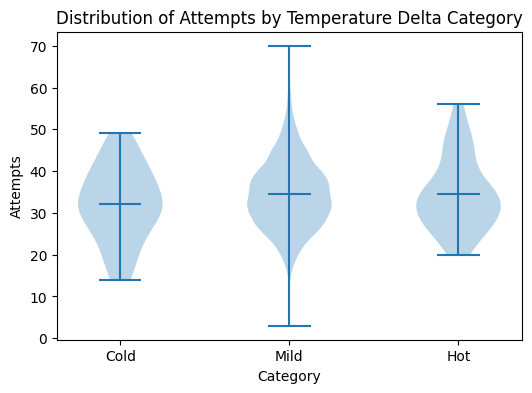

In [7]:
plt.figure(figsize=(6, 4))
data = [pace_of_play_data[pace_of_play_data["category"] == cat]["attempts"] for cat in category_order]
plt.violinplot(data, showmeans=True)
plt.xticks([1, 2, 3], category_order)
plt.xlabel("Category")
plt.ylabel("Attempts")
plt.title("Distribution of Attempts by Temperature Delta Category")
plt.show()

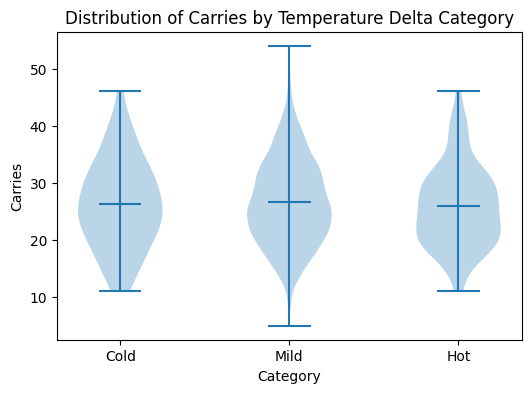

In [8]:
plt.figure(figsize=(6, 4))
data = [pace_of_play_data[pace_of_play_data["category"] == cat]["carries"] for cat in category_order]
plt.violinplot(data, showmeans=True)
plt.xticks([1, 2, 3], category_order)
plt.xlabel("Category")
plt.ylabel("Carries")
plt.title("Distribution of Carries by Temperature Delta Category")
plt.show()

As seen from these violin plots, our suspicions seem to be confirmed. The difference in pace of play doesn't come from passing plays and rushing plays equally. Rather, the difference seems to be from a lower likelihood of cold weather games seeing high passing play frequency. Intuitively, this aligns with our understanding as NFL viewers, as passing plays are more likely to result in a game clock stoppage because of the possibility of an incompletion.